In [187]:
# Reference Article:
#https://keats.kcl.ac.uk/pluginfile.php/4265624/mod_resource/content/2/w8_reading_Sparks_et_al-2010-Population%2C_Space_and_Place.pdf

In [163]:
import sys
import os
import urllib
import zipfile
import geopandas as gpd
import seaborn as sns
import shapely.geometry
from shapely.geometry import Point
import libpysal as lps
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysal.viz as viz
import re
import shapely
import random 
random.seed(123456789) # For reproducibility
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import matplotlib as mpl
mpl.use('TkAgg')
# Make sure output is into notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

In [164]:
#DOWNLOAD ETHNICITY DATA

pdf = pd.read_csv( # pdf == pandas dataframe
    'https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOA%20Data.csv.gz?raw=true',
    compression='gzip', low_memory=False) # The 'low memory' option means pandas doesn't guess data type

pdf.drop(['GreenspaceArea', 'RoadsArea', 'Owned', 'SharedOwnshp', 'SocialRented', 'PrivateRented', 'RentFree', 
         'ORroomsM1','SmallHost', 'geometry', 'MultiHost', 'PropertyCount', 'ORbedsM1',
         'RoomsHH','BedsHH', 'MedianIncome', 'SumPrice','MeanPrice',
         'MedianPrice','EntireHome',
         'PrivateRoom', 'SharedRoom'
        ], axis=1, inplace=True)

In [165]:
pdf['Whiteprop'] = pd.Series((pdf['White'] / pdf['USUALRES']))
pdf['Whitescore'] = pd.Series((pdf['Whiteprop'] - pdf['Whiteprop'].mean()) / pdf['Whiteprop'].std())
pdf['Blackprop'] = pd.Series((pdf['Black'] / pdf['USUALRES']))
pdf['Blackscore'] = pd.Series((pdf['Blackprop'] - pdf['Blackprop'].mean()) / pdf['Blackprop'].std())
pdf['Asianprop'] = pd.Series((pdf['Asian'] / pdf['USUALRES']))
pdf['Asianscore'] = pd.Series((pdf['Asianprop'] - pdf['Asianprop'].mean()) / pdf['Asianprop'].std())
pdf['Multiprop'] = pd.Series((pdf['MultiEthnic'] / pdf['USUALRES']))
pdf['Multiscore'] = pd.Series((pdf['Multiprop'] - pdf['Multiprop'].mean()) / pdf['Multiprop'].std())
pdf['Otherprop'] = pd.Series((pdf['OtherEthnic'] / pdf['USUALRES']))
pdf['Otherscore'] = pd.Series((pdf['Otherprop'] - pdf['Otherprop'].mean()) / pdf['Otherprop'].std())
pdf.head(1)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Whiteprop,Whitescore,Blackprop,Blackscore,Asianprop,Asianscore,Multiprop,Multiscore,Otherprop,Otherscore
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,0.8451,1.1690,0.0075,-1.0999,0.0874,-0.5694,0.0369,-0.6367,0.0232,-0.3761


In [166]:
#DOWNLOAD LSOA + IMD DATA

from shapely.geometry import Polygon
lsoas=gpd.read_file('data/LSOA_IMD2019.shp')

lsoas.head(1)

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rand,IMD_Decile,LSOA01NM,LADcd,...,OutRank,OutDec,TotScore,TotRank,TotDec,DepChi,Pop16_59,Pop60_,WorkPop,geometry
0,1,E01000001,City of London 001A,City of London 001A,"133,320.7689","2,291.8461",29199,9,City of London 001A,E09000001,...,1615,1,1296,175,656,465,715.0000,"343,907.4198","3,682.4394","POLYGON ((532095.563 181577.351, 532095.125 18..."


In [167]:
db=pdf.join(lsoa.set_index(['lsoa11cd']), on=['LSOA11CD'], how='left')
db_new=db.dropna()
db.head(1)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,WBScore,IndScore,OutScore,TotScore,WorkPop,geometry,Mean Price,Small Host,Multiple Location Host,Property Count
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,3.5870,0.0060,1.5030,1296,"3,682.4394","POLYGON ((532095.563 181577.351, 532095.125 18...",148.4444,8.0000,10.0000,18.0000


In [168]:
db_geo = gpd.GeoDataFrame(db_new, geometry='geometry')
db_geo.to_file(driver='ESRI Shapefile', filename='data/lsoa_IMD_ethnicity.shp')

In [169]:
gdf=gpd.read_file('data/lsoa_IMD_ethnicity.shp')
gdf.head(1)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,WBScore,IndScore,OutScore,TotScore,WorkPop,Mean Price,Small Host,Multiple L,Property C,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,3.5870,0.0060,1.5030,1296,"3,682.4394",148.4444,8.0000,10.0000,18.0000,"POLYGON ((532095.563 181577.351, 532095.125 18..."


In [157]:
#CALCULATING GLOBAL MORAN'S I VALUES FOR VARIABLES IN THE ANALYSIS

# IMD DECILE

#w_queen = ps.lib.weights.Queen.from_dataframe(gdf)

#from pysal.explore import esda 
#binary = 1 * (gdf['IMD_Decile']> gdf['IMD_Decile'].median()) # convert back to binary
#W_queen = lps.weights.Queen.from_dataframe(gdf)
#W_queen.transform = 'b'
#np.random.seed(12345)
#jc = esda.join_counts.Join_Counts(binary, W_queen)

In [170]:
#CALCULATING GLOBAL MORAN'S I VALUES FOR VARIABLES IN THE ANALYSIS
w_queen = ps.lib.weights.Queen.from_dataframe(gdf)
from pysal.explore import esda 
np.random.seed(12345)

#IMD_Decile
I_imd = ps.explore.esda.Moran(gdf['IMD_Decile'].values, w_queen)  # Moran's I
I_imd.I, I_imd.EI, I_imd.p_sim 

('WARNING: ', 912, ' is an island (no neighbors)')
('WARNING: ', 943, ' is an island (no neighbors)')


(0.6331556042105227, -0.0002239140170174653, 0.001)

In [175]:
#Blackscore
I_black = ps.explore.esda.Moran(gdf['Blackscore'].values, w_queen)  # Moran's I
I_black.I, I_black.EI, I_black.p_sim 

(0.775598188617894, -0.0002239140170174653, 0.001)

In [176]:
#Whitescore
I_white = ps.explore.esda.Moran(gdf['Whitescore'].values, w_queen)  # Moran's I
I_white.I, I_white.EI, I_white.p_sim 

(0.8364901725500445, -0.0002239140170174653, 0.001)

In [177]:
#Asianscore
I_asian = ps.explore.esda.Moran(gdf['Asianscore'].values, w_queen)  # Moran's I
I_asian.I, I_asian.EI, I_asian.p_sim 

(0.8810846115206455, -0.0002239140170174653, 0.001)

In [178]:
#Multiscore
I_multi = ps.explore.esda.Moran(gdf['Multiscore'].values, w_queen)  # Moran's I
I_multi.I, I_multi.EI, I_multi.p_sim 

(0.6325520297557021, -0.0002239140170174653, 0.001)

In [179]:
#Otherscore
I_other = ps.explore.esda.Moran(gdf['Otherscore'].values, w_queen)  # Moran's I
I_other.I, I_other.EI, I_other.p_sim 

(0.7257009635033251, -0.0002239140170174653, 0.001)

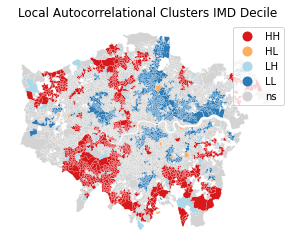

In [180]:
#PRODUCING LOCAL AUTOCORRELATION CLUSTER MAPS FOR EACH VARIABLE

#IMD
lisa_imd = ps.explore.esda.Moran_Local(gdf['IMD_Decile'].values, w_queen, permutations=999)
from pysal.viz.splot.esda import lisa_cluster
fig = lisa_cluster(lisa_imd, gdf)
plt.title("Local Autocorrelational Clusters IMD Decile")
plt.show()

#remember high imd = less deprived 

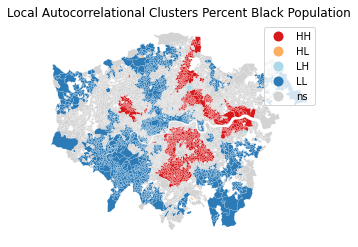

In [182]:
#Black
lisa_black = ps.explore.esda.Moran_Local(gdf['Blackscore'].values, w_queen, permutations=999)
fig = lisa_cluster(lisa_black, gdf)
plt.title("Local Autocorrelational Clusters Percent Black Population")
plt.show()

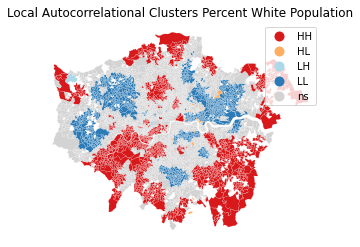

In [183]:
#White
lisa_white = ps.explore.esda.Moran_Local(gdf['Whitescore'].values, w_queen, permutations=999)
fig = lisa_cluster(lisa_white, gdf)
plt.title("Local Autocorrelational Clusters Percent White Population")
plt.show()

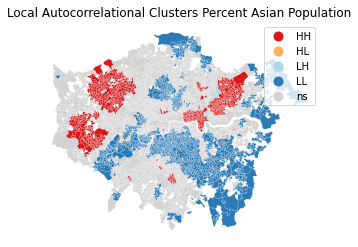

In [184]:
#Asian
lisa_asian = ps.explore.esda.Moran_Local(gdf['Asianscore'].values, w_queen, permutations=999)
fig = lisa_cluster(lisa_asian, gdf)
plt.title("Local Autocorrelational Clusters Percent Asian Population")
plt.show()

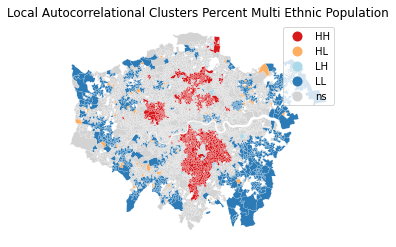

In [185]:
#Multi
lisa_multi = ps.explore.esda.Moran_Local(gdf['Multiscore'].values, w_queen, permutations=999)
fig = lisa_cluster(lisa_multi, gdf)
plt.title("Local Autocorrelational Clusters Percent Multi Ethnic Population")
plt.show()

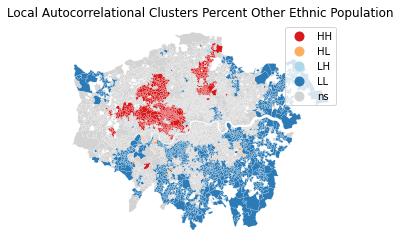

In [186]:
#Other
lisa_other = ps.explore.esda.Moran_Local(gdf['Otherscore'].values, w_queen, permutations=999)
fig = lisa_cluster(lisa_other, gdf)
plt.title("Local Autocorrelational Clusters Percent Other Ethnic Population")
plt.show()